In [84]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})
import lightgbm as lgb
sys.path.insert(0, 'C:/Users/vitil/OneDrive/Desktop/btc_project')

In [85]:
source_file = 'autoreg.csv'
df = pd.read_csv(f"C:/Users/vitil/OneDrive/Desktop/btc_project/data/{source_file}")
df= df.dropna()
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16471 entries, 3 to 16473
Columns: 2356 entries, ds to target_max_w720_lag1
dtypes: datetime64[ns](1), float64(2355)
memory usage: 296.2 MB


In [86]:
df = df.tail(12000)

In [87]:
df.head(5)

,ds,y,weights,y_mean_ratio_3_6_lag1,y_mean_ratio_3_12_lag1,y_mean_ratio_3_24_lag1,y_mean_ratio_3_48_lag1,y_mean_ratio_3_120_lag1,y_mean_ratio_3_168_lag1,y_mean_ratio_3_336_lag1,...,target_std_w720_lag1,target_skew_w720_lag1,target_kurt_w720_lag1,target_min_w720_lag1,target_q10_w720_lag1,target_q25_w720_lag1,target_q50_w720_lag1,target_q75_w720_lag1,target_q90_w720_lag1,target_max_w720_lag1
4474,2024-02-28 01:00:00,56772.64,0.082496,0.999809,1.000118,1.006778,1.044763,1.083410,1.089875,1.095182,...,226.894725,1.176051,6.055736,-819.593946,-124.171768,-6.391215,82.450750,192.046163,338.217741,1397.082582
4475,2024-02-28 02:00:00,56925.10,0.082496,1.000765,0.999911,1.005327,1.041919,1.081712,1.088530,1.093953,...,226.961704,1.179719,6.054696,-819.593946,-124.171768,-6.691415,82.404176,188.655967,338.217741,1397.082582
4476,2024-02-28 03:00:00,56916.40,0.082496,1.000233,0.999329,1.004203,1.039059,1.080005,1.087213,1.092769,...,227.022371,1.177334,6.042418,-819.593946,-124.171768,-6.691415,82.404176,192.046163,338.217741,1397.082582
4477,2024-02-28 04:00:00,57207.50,0.082496,0.999030,0.998500,1.002701,1.036343,1.078387,1.085976,1.091674,...,227.011918,1.178083,6.045044,-819.593946,-124.171768,-6.691415,82.404176,192.046163,338.217741,1397.082582
4478,2024-02-28 05:00:00,57080.68,0.082496,1.000654,1.000800,1.004172,1.036751,1.080113,1.088094,1.093968,...,227.278789,1.169873,5.995123,-819.593946,-124.171768,-6.391215,82.450750,192.702681,338.779360,1397.082582


In [88]:
from catboost import CatBoostRegressor, Pool

# Assume df is loaded with columns: ds, y, target, weights, and feature columns

# Data preprocessing
n_samples = len(df)
train_idx = int(0.6 * n_samples)
val_idx = int(0.9 * n_samples)

# Create datasets
train_data = df.iloc[:train_idx]
val_data = df.iloc[train_idx:val_idx]
test_data = df.iloc[val_idx:]

# Create train_data2 for retraining (includes train + validation)
train_data2 = df.iloc[:val_idx]

# Normalize weights for initial training
max_weight = train_data['weights'].max()
train_data['weights'] = train_data['weights'] / max_weight

# Define feature columns
feature_cols = [col for col in df.columns if col not in ['ds', 'y', 'target', 'weights']]

# Prepare data splits
X_train = train_data[feature_cols].values
y_train = train_data['target'].values
X_val = val_data[feature_cols].values
y_val = val_data['target'].values
X_test = test_data[feature_cols].values
y_test = test_data['target'].values

# Create pools for CatBoost
train_pool = Pool(
    data=X_train,
    label=y_train,
    weight=train_data['weights'].values,
    feature_names=feature_cols
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    feature_names=feature_cols
)

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Train samples: 7200
Validation samples: 3600
Test samples: 1200


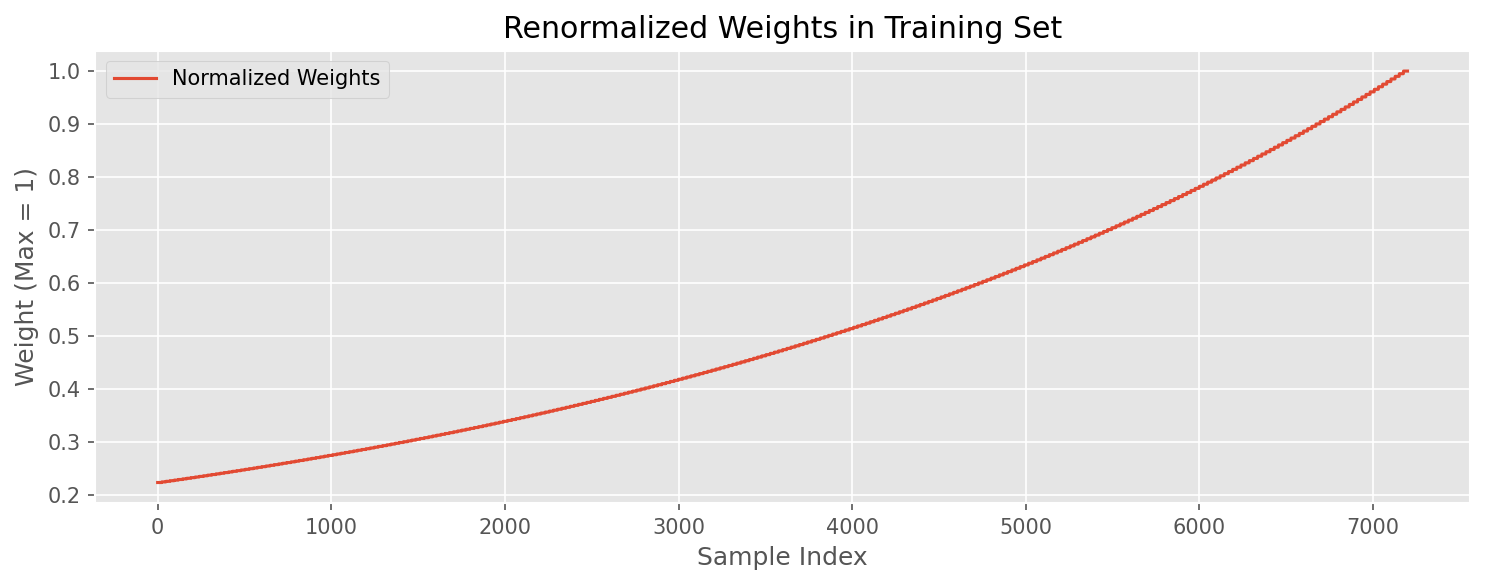

In [89]:
plt.figure(figsize=(10, 4))
plt.plot(train_data['weights'].values, label='Normalized Weights')
plt.title('Renormalized Weights in Training Set')
plt.xlabel('Sample Index')
plt.ylabel('Weight (Max = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
alpha = 1.0
k = 10

class CustomLoss:
    def __init__(self, alpha=0.6, k=2.5):
        self.alpha = alpha
        self.k = k
    
    def calc_ders_range(self, approxes, targets, weights):
        # approxes and targets are indexed containers, not numpy arrays
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        
        # Iterate through each element
        for i in range(len(approxes)):
            # Get individual values
            approx = float(approxes[i])
            target = float(targets[i])
            
            # Calculate z for sigmoid
            z = target * approx
            
            # Avoid overflow in exp
            if z > 5000:
                sigmoid = 1.0
            elif z < -5000:
                sigmoid = 0.0
            else:
                sigmoid = 1.0 / (1.0 + np.exp(-self.k * z))
            
            # First derivative (gradient) - CatBoost expects negative gradient
            grad = -(2 * self.alpha * (approx - target) - (1 - self.alpha) * target * sigmoid)
            
            # Second derivative (hessian) - CatBoost expects negative hessian
            hess = -(2 * self.alpha + (1 - self.alpha) * self.k * target**2 * sigmoid * (1 - sigmoid))
            
            # Apply weights if provided
            if weights is not None:
                grad *= float(weights[i])
                hess *= float(weights[i])
            
            result.append((grad, hess))
        
        return result


In [91]:
class CustomLossMetric:
    """
    Implements the exact same metric as the LightGBM softplus_custom_eval_metric.
    Calculates: alpha * (y_pred - y_true)^2 + (1-alpha)/k * log(1 + exp(-k*y_true*y_pred))
    """
    def __init__(self, alpha=0.6, k=2.5):
        self.alpha = alpha
        self.k = k
    
    def evaluate(self, approxes, target, weight):
        # approxes is a list of lists for some reason in CatBoost
        assert len(approxes) == 1
        approx = approxes[0]
        assert len(target) == len(approx)
        
        error_sum = 0.0
        weight_sum = 0.0
        
        # Calculate the actual loss value for each prediction
        for i in range(len(approx)):
            # Get individual values
            y_pred = float(approx[i])
            y_true = float(target[i])
            
            # Calculate the loss components
            # MSE component
            mse_component = self.alpha * (y_pred - y_true)**2
            
            # Softplus penalty component
            z = y_true * y_pred
            
            # Calculate softplus: log(1 + exp(-k*z))
            # Use stable computation to avoid overflow
            if -self.k * z > 700:
                # When -k*z is very large, log(1 + exp(-k*z)) ≈ -k*z
                penalty = -self.k * z
            else:
                # Normal computation
                penalty = np.log(1 + np.exp(-self.k * z))
            
            # Apply scaling factor (1-alpha)/k
            penalty_component = (1 - self.alpha) / self.k * penalty
            
            # Total loss for this sample
            loss_i = mse_component + penalty_component
            
            # Handle weights
            weight_i = 1.0 if weight is None else float(weight[i])
            
            error_sum += weight_i * loss_i
            weight_sum += weight_i
        
        return error_sum, weight_sum
    
    def get_final_error(self, error, weight):
        # Return the average loss
        return error / (weight + 1e-38)  # Add small epsilon to avoid division by zero
    
    def is_max_optimal(self):
        # Lower loss is better, so return False
        return False

In [92]:
params = {
    'loss_function': CustomLoss(alpha=alpha, k=k),
    'eval_metric': CustomLossMetric(alpha=alpha, k=k), 
    'bootstrap_type':"No",
    'grow_policy': 'SymmetricTree',
    'sampling_frequency':'PerTree',
    'iterations': 1200,
    'learning_rate': 0.005,
    'depth': 8,
    'rsm': 0.85,
    'thread_count': -1,
    'random_seed': 42,
    'l2_leaf_reg': 0.1,
    'allow_writing_files': False,
    'early_stopping_rounds': 500,
    'has_time':True,
    'task_type': 'CPU',
}

model_mean = CatBoostRegressor(**params)
model_mean.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=False,
    verbose=50
)

0:	learn: 193598.2464478	test: 293677.6073361	best: 293677.6073361 (0)	total: 330ms	remaining: 6m 35s
50:	learn: 179239.7523854	test: 286136.8162565	best: 286136.8162565 (50)	total: 18.4s	remaining: 6m 55s
100:	learn: 168206.7851571	test: 280982.7465774	best: 280982.7465774 (100)	total: 36.1s	remaining: 6m 32s
150:	learn: 159102.1987241	test: 277564.1931592	best: 277564.1931592 (150)	total: 53.7s	remaining: 6m 12s
200:	learn: 151481.4619745	test: 275042.8235773	best: 275042.8235773 (200)	total: 1m 11s	remaining: 5m 54s
250:	learn: 144816.4670740	test: 273320.5586880	best: 273320.5586880 (250)	total: 1m 29s	remaining: 5m 36s
300:	learn: 138952.8419919	test: 272509.1264137	best: 272508.6425702 (299)	total: 1m 46s	remaining: 5m 18s
350:	learn: 133997.9364401	test: 271614.0045970	best: 271614.0045970 (350)	total: 2m 4s	remaining: 5m
400:	learn: 129582.4317873	test: 271075.8799853	best: 271075.8799853 (400)	total: 2m 21s	remaining: 4m 41s
450:	learn: 125549.8442561	test: 270724.4049270	best

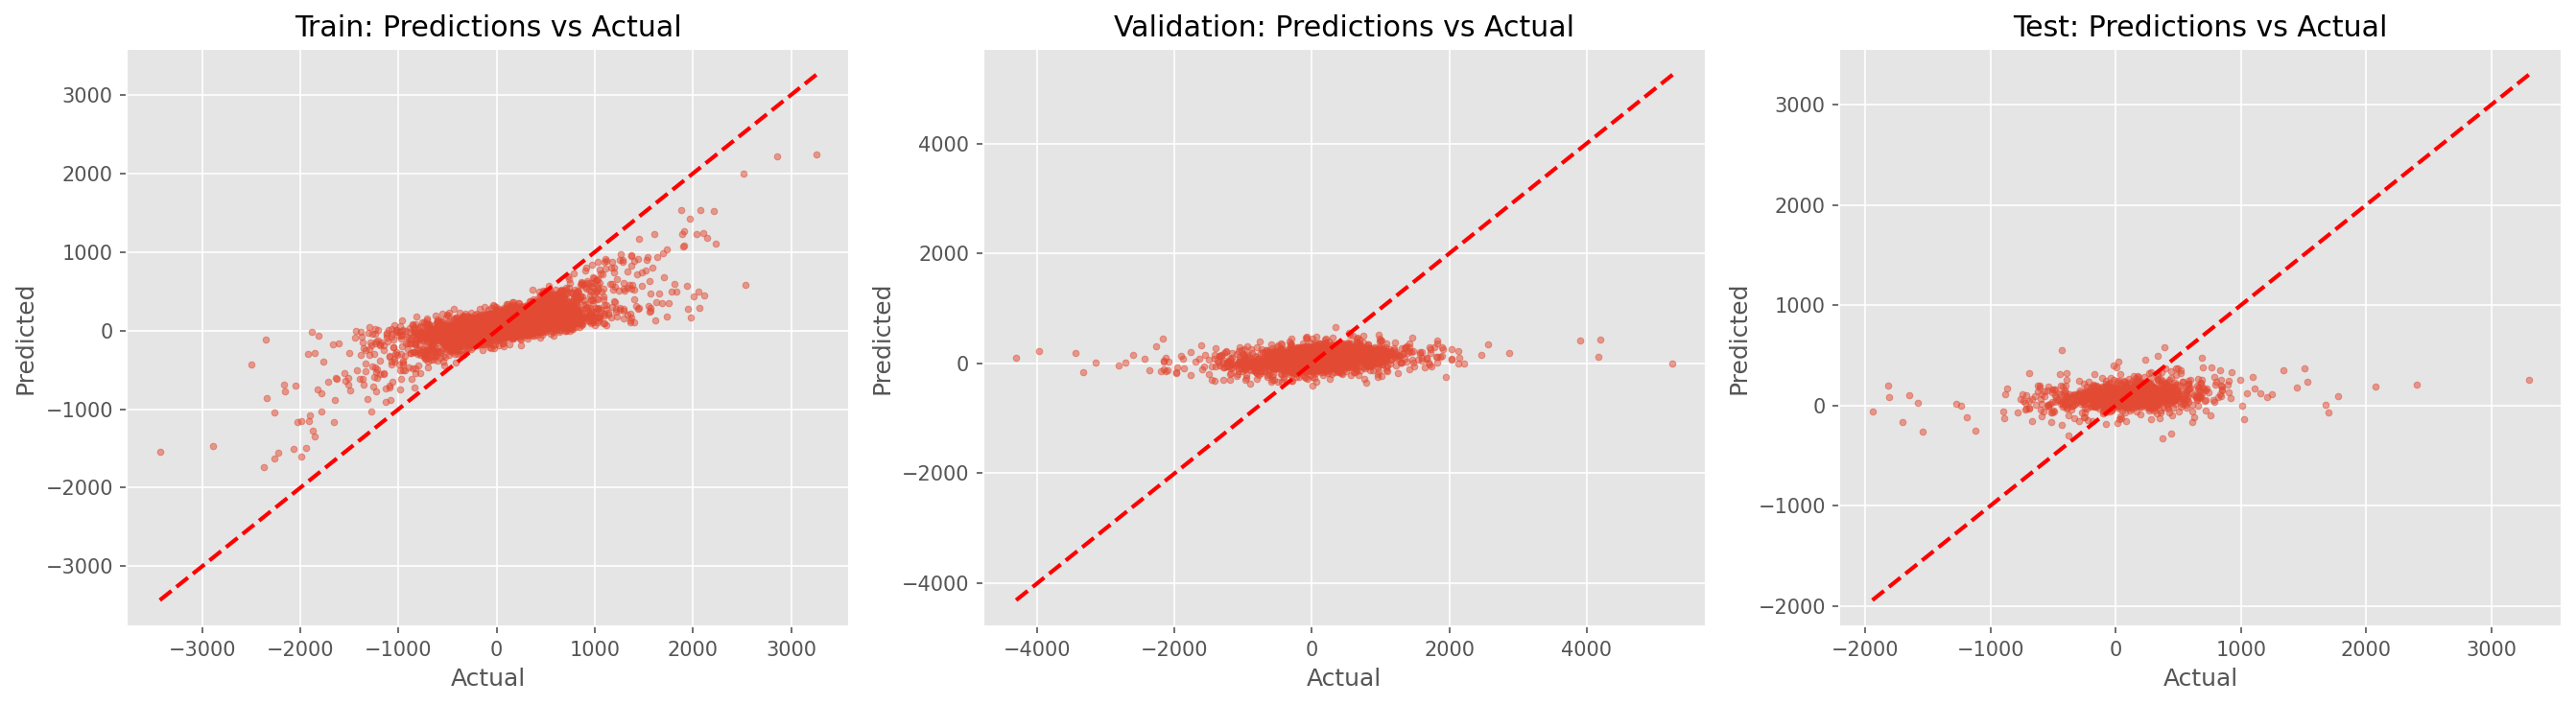


Model Performance Metrics:
                           Train  Validation        Test
Mean Absolute Loss    208.397356  334.210650  252.958304
Directional Accuracy    0.730833    0.636667    0.674167


In [93]:
# Cell 8: Model evaluation
# Generate predictions
train_pred = model_mean.predict(X_train)
val_pred = model_mean.predict(X_val)
test_pred = model_mean.predict(X_test)

# Create 3 subplots for predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train predictions
axes[0].scatter(y_train, train_pred, alpha=0.5, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Train: Predictions vs Actual')

# Validation predictions
axes[1].scatter(y_val, val_pred, alpha=0.5, s=10)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Validation: Predictions vs Actual')

# Test predictions
axes[2].scatter(y_test, test_pred, alpha=0.5, s=10)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')
axes[2].set_title('Test: Predictions vs Actual')

plt.tight_layout()
plt.show()

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    # Mean absolute loss
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Directional accuracy
    direction_correct = np.sum(np.sign(y_true) == np.sign(y_pred))
    directional_acc = direction_correct / len(y_true)
    
    return mae, directional_acc

# Generate metrics table
train_mae, train_dir_acc = calculate_metrics(y_train, train_pred)
val_mae, val_dir_acc = calculate_metrics(y_val, val_pred)
test_mae, test_dir_acc = calculate_metrics(y_test, test_pred)

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Train': [train_mae, train_dir_acc],
    'Validation': [val_mae, val_dir_acc],
    'Test': [test_mae, test_dir_acc]
}, index=['Mean Absolute Loss', 'Directional Accuracy'])

print("\nModel Performance Metrics:")
print(metrics_df)

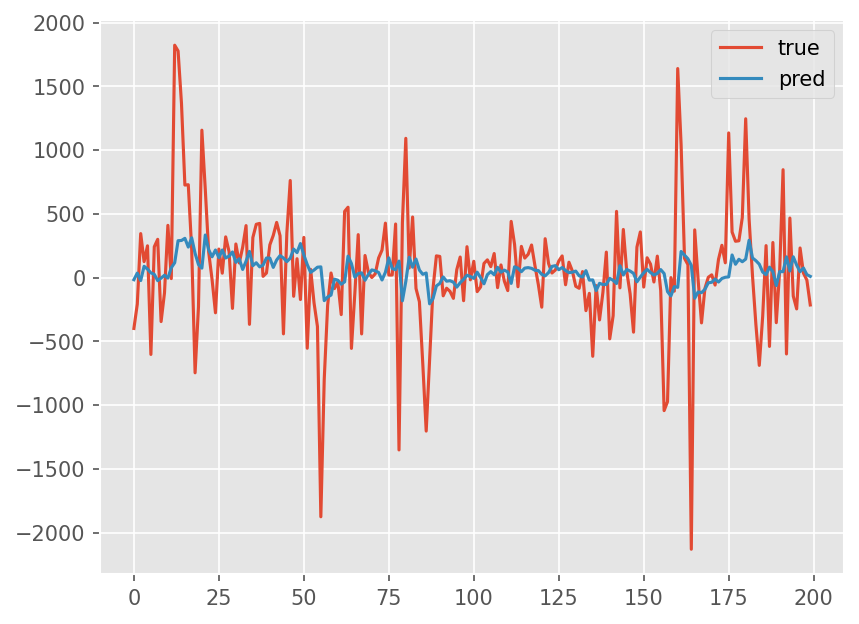

In [94]:
k=200
plt.plot(y_val[:k], label = 'true')
plt.plot(val_pred[:k],label = 'pred')
plt.legend()
plt.show()

In [95]:
# Get the number of iterations achieved
best_iteration = model_mean.get_best_iteration()
print(f"Best iteration achieved: {best_iteration}")

# Step 2: Calculate residuals on validation set for one-step-ahead forecast
print("\nStep 2: Calculating residuals on validation set...")
y_val_pred = model_mean.predict(X_val)
residuals_val = y_val - y_val_pred

# Prepare data for multi-quantile model
val_pool_quantile = Pool(
    data=X_val,
    label=residuals_val,  # Target is residuals
    feature_names=feature_cols
)

# Extended quantile mapping
quantile_mapping = {
    99.5: ['0.005', '0.995'],
    99: ['0.01', '0.99'],
    95: ['0.025', '0.975'],
    90: ['0.05', '0.95'],
    80: ['0.10', '0.90'],
    70: ['0.15', '0.85'],
    60: ['0.20', '0.80'],
    50: ['0.25', '0.75'],
    40: ['0.30', '0.70'],
    30: ['0.35', '0.65'],
    20: ['0.40', '0.60'],
    10: ['0.45', '0.55']
}

# Extended quantiles list
quantiles = [
    0.005, 0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25,
    0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65,
    0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975, 0.99, 0.995
]

# Extended levels array
levels = np.array([99.5, 99, 95, 90, 80, 70, 60, 50, 40, 30, 20, 10])

# Convert quantiles to string format for CatBoost
quantile_str = str(quantiles).replace('[','').replace(']','')

# Step 3: Fit multi-quantile model on validation residuals
print("\nStep 3: Training multi-quantile model on residuals...")

model_quantiles = CatBoostRegressor(
    loss_function=f'MultiQuantile:alpha={quantile_str}',
    thread_count=-1,
    bootstrap_type="No",
    grow_policy='Lossguide',  
    sampling_frequency='PerTree',
    iterations=700,
    learning_rate=0.015,
    max_depth=6,
    rsm=0.85,
    min_data_in_leaf=10,
    verbose=50
)

model_quantiles.fit(val_pool_quantile)

Best iteration achieved: 1148

Step 2: Calculating residuals on validation set...

Step 3: Training multi-quantile model on residuals...
0:	learn: 106.8030152	total: 519ms	remaining: 6m 2s
50:	learn: 103.5059815	total: 23.9s	remaining: 5m 4s
100:	learn: 101.3440850	total: 43.4s	remaining: 4m 17s
150:	learn: 99.2157313	total: 1m 4s	remaining: 3m 56s
200:	learn: 97.3841293	total: 1m 26s	remaining: 3m 35s
250:	learn: 95.5309802	total: 1m 49s	remaining: 3m 16s
300:	learn: 93.8390747	total: 2m 14s	remaining: 2m 58s
350:	learn: 92.3021331	total: 2m 37s	remaining: 2m 36s
400:	learn: 90.9236518	total: 2m 59s	remaining: 2m 13s
450:	learn: 89.7498007	total: 3m 19s	remaining: 1m 49s
500:	learn: 88.7325830	total: 3m 37s	remaining: 1m 26s
550:	learn: 88.0350688	total: 3m 51s	remaining: 1m 2s
600:	learn: 87.5429131	total: 4m 3s	remaining: 40.2s
650:	learn: 87.1125225	total: 4m 14s	remaining: 19.2s
699:	learn: 86.7870307	total: 4m 24s	remaining: 0us


In [96]:
# Step 4 & 5: Retrain mean model on combined train+validation data
print("\nStep 5: Retraining mean model on extended training set...")

# Normalize weights for train_data2
max_weight2 = train_data2['weights'].max()
train_data2['weights'] = train_data2['weights'] / max_weight2

X_train2 = train_data2[feature_cols].values
y_train2 = train_data2['target'].values

train_pool2 = Pool(
    data=X_train2,
    label=y_train2,
    weight=train_data2['weights'].values,
    feature_names=feature_cols
)

params_retrain = params.copy()
params_retrain['iterations'] = 1500  #best_iteration + 200 if best_iteration else 1500
params_retrain['early_stopping_rounds'] = None 
params_retrain['used_ram_limit'] = '4gb'

model_mean_final = CatBoostRegressor(**params_retrain)
model_mean_final.fit(
    train_pool2,
    verbose=50
)



Step 5: Retraining mean model on extended training set...
0:	learn: 246253.5856335	total: 378ms	remaining: 9m 26s
50:	learn: 230472.8990535	total: 20.6s	remaining: 9m 44s
100:	learn: 218086.7820182	total: 39.6s	remaining: 9m 8s
150:	learn: 208199.4069108	total: 57.9s	remaining: 8m 36s
200:	learn: 199818.5742905	total: 1m 16s	remaining: 8m 12s
250:	learn: 192609.5562921	total: 1m 34s	remaining: 7m 51s
300:	learn: 186288.1357773	total: 1m 52s	remaining: 7m 29s
350:	learn: 180650.8719663	total: 2m 11s	remaining: 7m 10s
400:	learn: 175591.2645973	total: 2m 29s	remaining: 6m 50s
450:	learn: 170792.5431802	total: 2m 47s	remaining: 6m 30s
500:	learn: 166363.1312208	total: 3m 6s	remaining: 6m 11s
550:	learn: 162228.7855231	total: 3m 24s	remaining: 5m 52s
600:	learn: 158335.2732564	total: 3m 42s	remaining: 5m 33s
650:	learn: 154606.4475122	total: 4m 1s	remaining: 5m 14s
700:	learn: 151268.6884347	total: 4m 19s	remaining: 4m 55s
750:	learn: 148128.6354004	total: 4m 37s	remaining: 4m 36s
800:	le


Step 6: Generating predictions with confidence bands...

Plotting results...


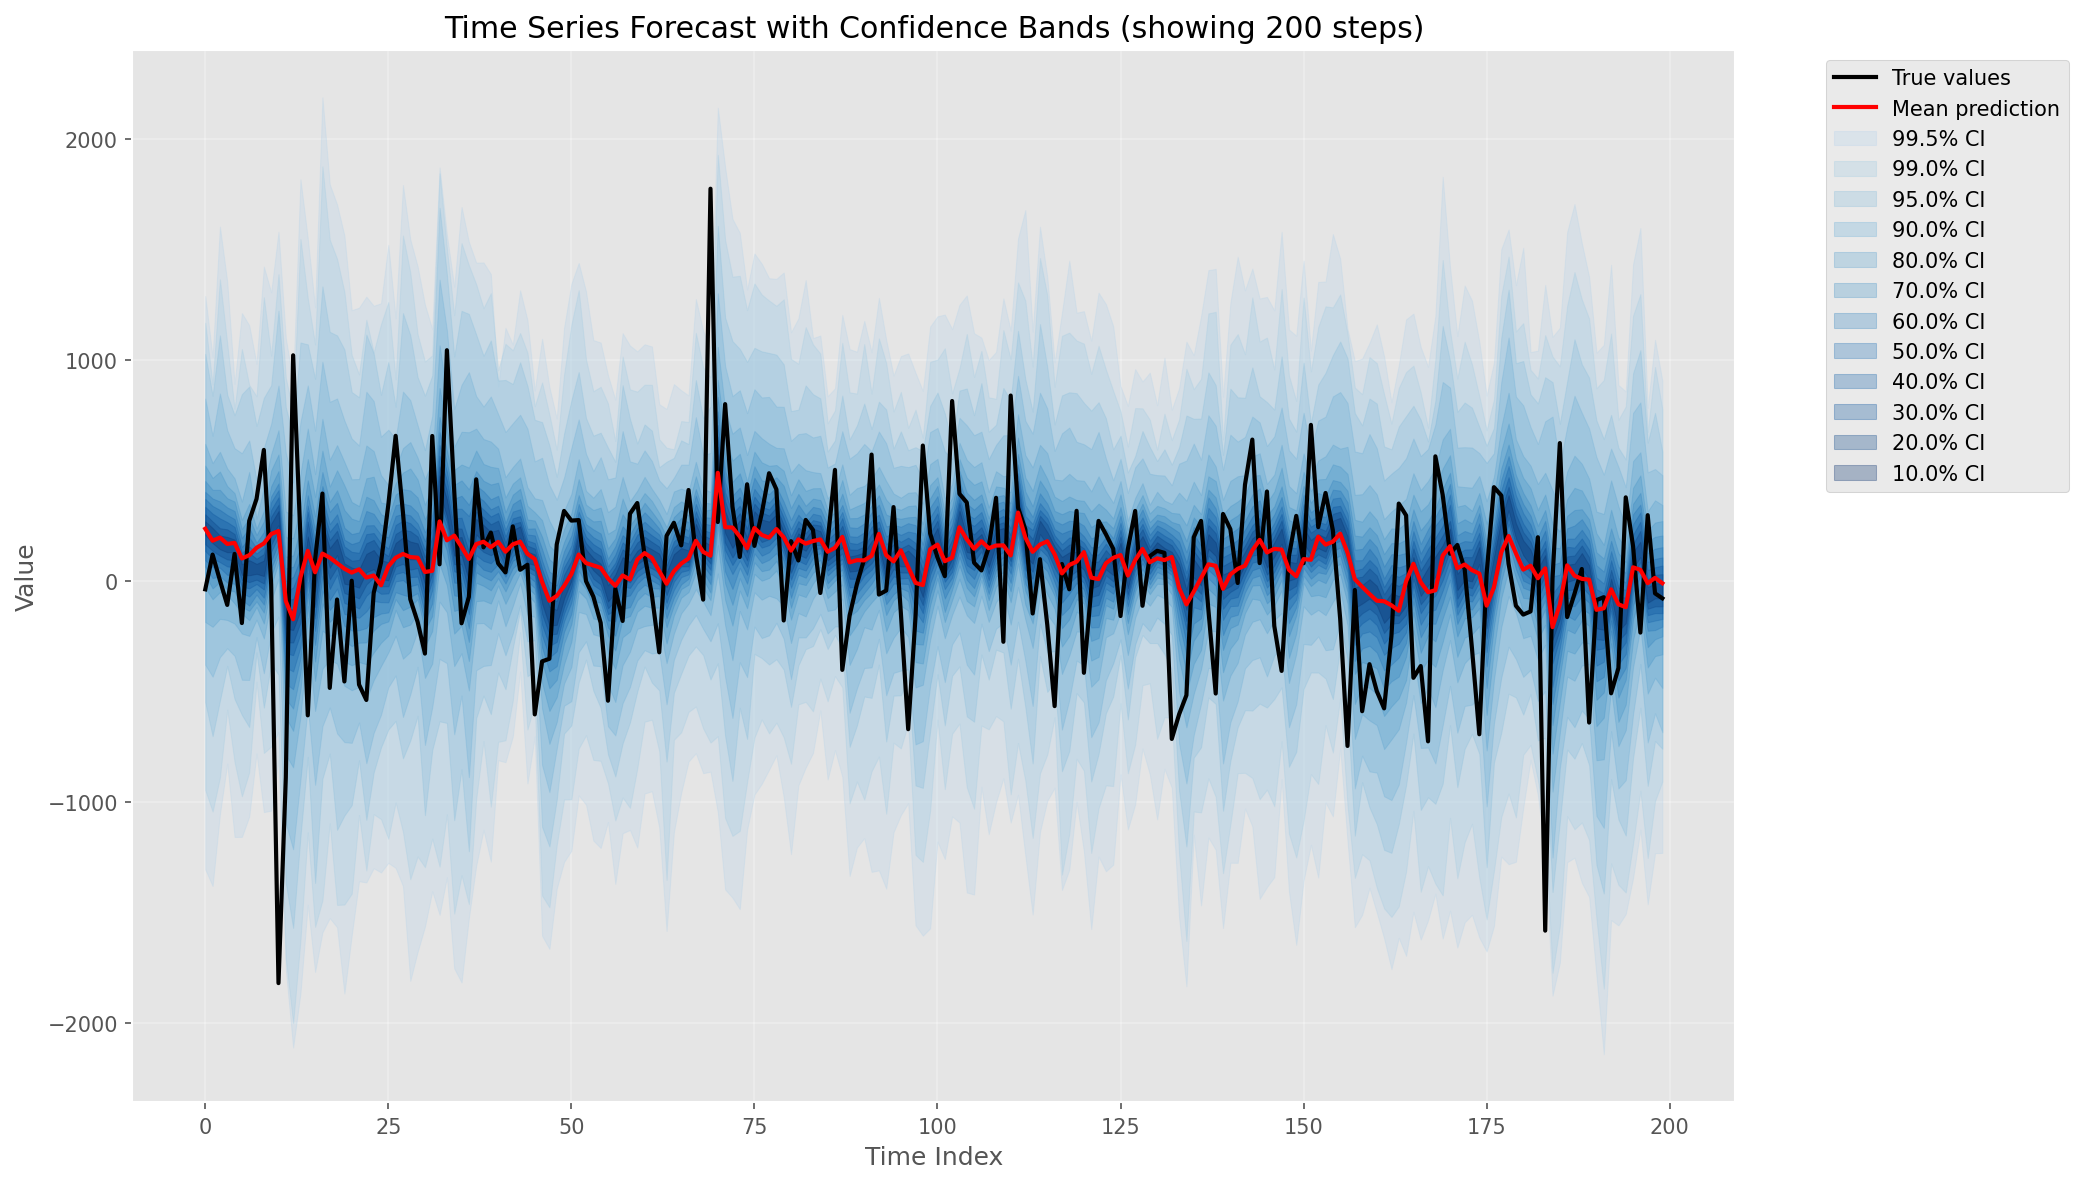


Test set metrics (full test set):
MAE: 252.6592
MAPE: 3.8244
RMSE: 374.0018
Pearson correlation: [[1.        0.2548523]
 [0.2548523 1.       ]]
95% CI coverage: 93.17%
90% CI coverage: 88.17%
80% CI coverage: 75.42%


In [97]:
from sklearn.metrics import mean_absolute_percentage_error

# Step 6: Reconstruct predictions with confidence bands on test set
print("\nStep 6: Generating predictions with confidence bands...")

# Get mean predictions on test set
y_test_mean = model_mean_final.predict(X_test)

# Get quantile predictions for residuals
residual_quantiles = model_quantiles.predict(X_test)

# Reconstruct full predictions
# Each row in residual_quantiles contains predictions for all quantiles
predictions = {}
predictions['mean'] = y_test_mean

# Add quantile predictions (mean + residual quantile)
for i, q in enumerate(quantiles):
    predictions[f'q{q}'] = y_test_mean + residual_quantiles[:, i]

# Plotting results
print("\nPlotting results...")

# Set plot length parameter
plot_len = 200  # Adjust this to show more or fewer time steps

# Ensure plot_len doesn't exceed test set length
plot_len = min(plot_len, len(y_test))

fig, ax = plt.subplots(figsize=(14, 8))

# Plot true values (only plot_len points)
ax.plot(range(plot_len), y_test[:plot_len], 'k-', label='True values', linewidth=2)

# Plot mean predictions (only plot_len points)
ax.plot(range(plot_len), predictions['mean'][:plot_len], 'r-', label='Mean prediction', linewidth=2)

# Plot confidence bands (only plot_len points)
colors = plt.cm.Blues(np.linspace(0.3, 0.995, len(levels)))
for i, level in enumerate(levels):
    lower_q, upper_q = quantile_mapping[level]
    lower_q_float = float(lower_q)
    upper_q_float = float(upper_q)
    
    ax.fill_between(
        range(plot_len),
        predictions[f'q{lower_q_float}'][:plot_len],
        predictions[f'q{upper_q_float}'][:plot_len],
        alpha=0.3,
        color=colors[i],
        label=f'{level}% CI'
    )

ax.set_xlabel('Time Index')
ax.set_ylabel('Value')
ax.set_title(f'Time Series Forecast with Confidence Bands (showing {plot_len} steps)')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print metrics (using full test set)
mae = np.mean(np.abs(y_test - predictions['mean']))
mape = mean_absolute_percentage_error(y_pred=predictions['mean'] , y_true=y_test)
rmse = np.sqrt(np.mean((y_test - predictions['mean'])**2))
corr=np.corrcoef(predictions['mean'],y_test )

print(f"\nTest set metrics (full test set):")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Pearson correlation: {corr}")

# Coverage statistics for confidence intervals (using full test set)
for level in [95, 90, 80]:
    lower_q, upper_q = quantile_mapping[level]
    lower_q_float = float(lower_q)
    upper_q_float = float(upper_q)
    
    coverage = np.mean((y_test >= predictions[f'q{lower_q_float}']) & 
                      (y_test <= predictions[f'q{upper_q_float}']))
    print(f"{level}% CI coverage: {coverage*100:.2f}%")

Number of weights used: 1000
Number of lags to use: 999
Current weight (should be 1.0): 1.0
First lag weight (should be ~-0.72): -0.72

=== Debug First Reconstruction ===
First diff prediction: 237.7322492473648
First reconstructed price: 111345.48496183346
First actual test price: 111327.69
Difference: 17.79496183345327


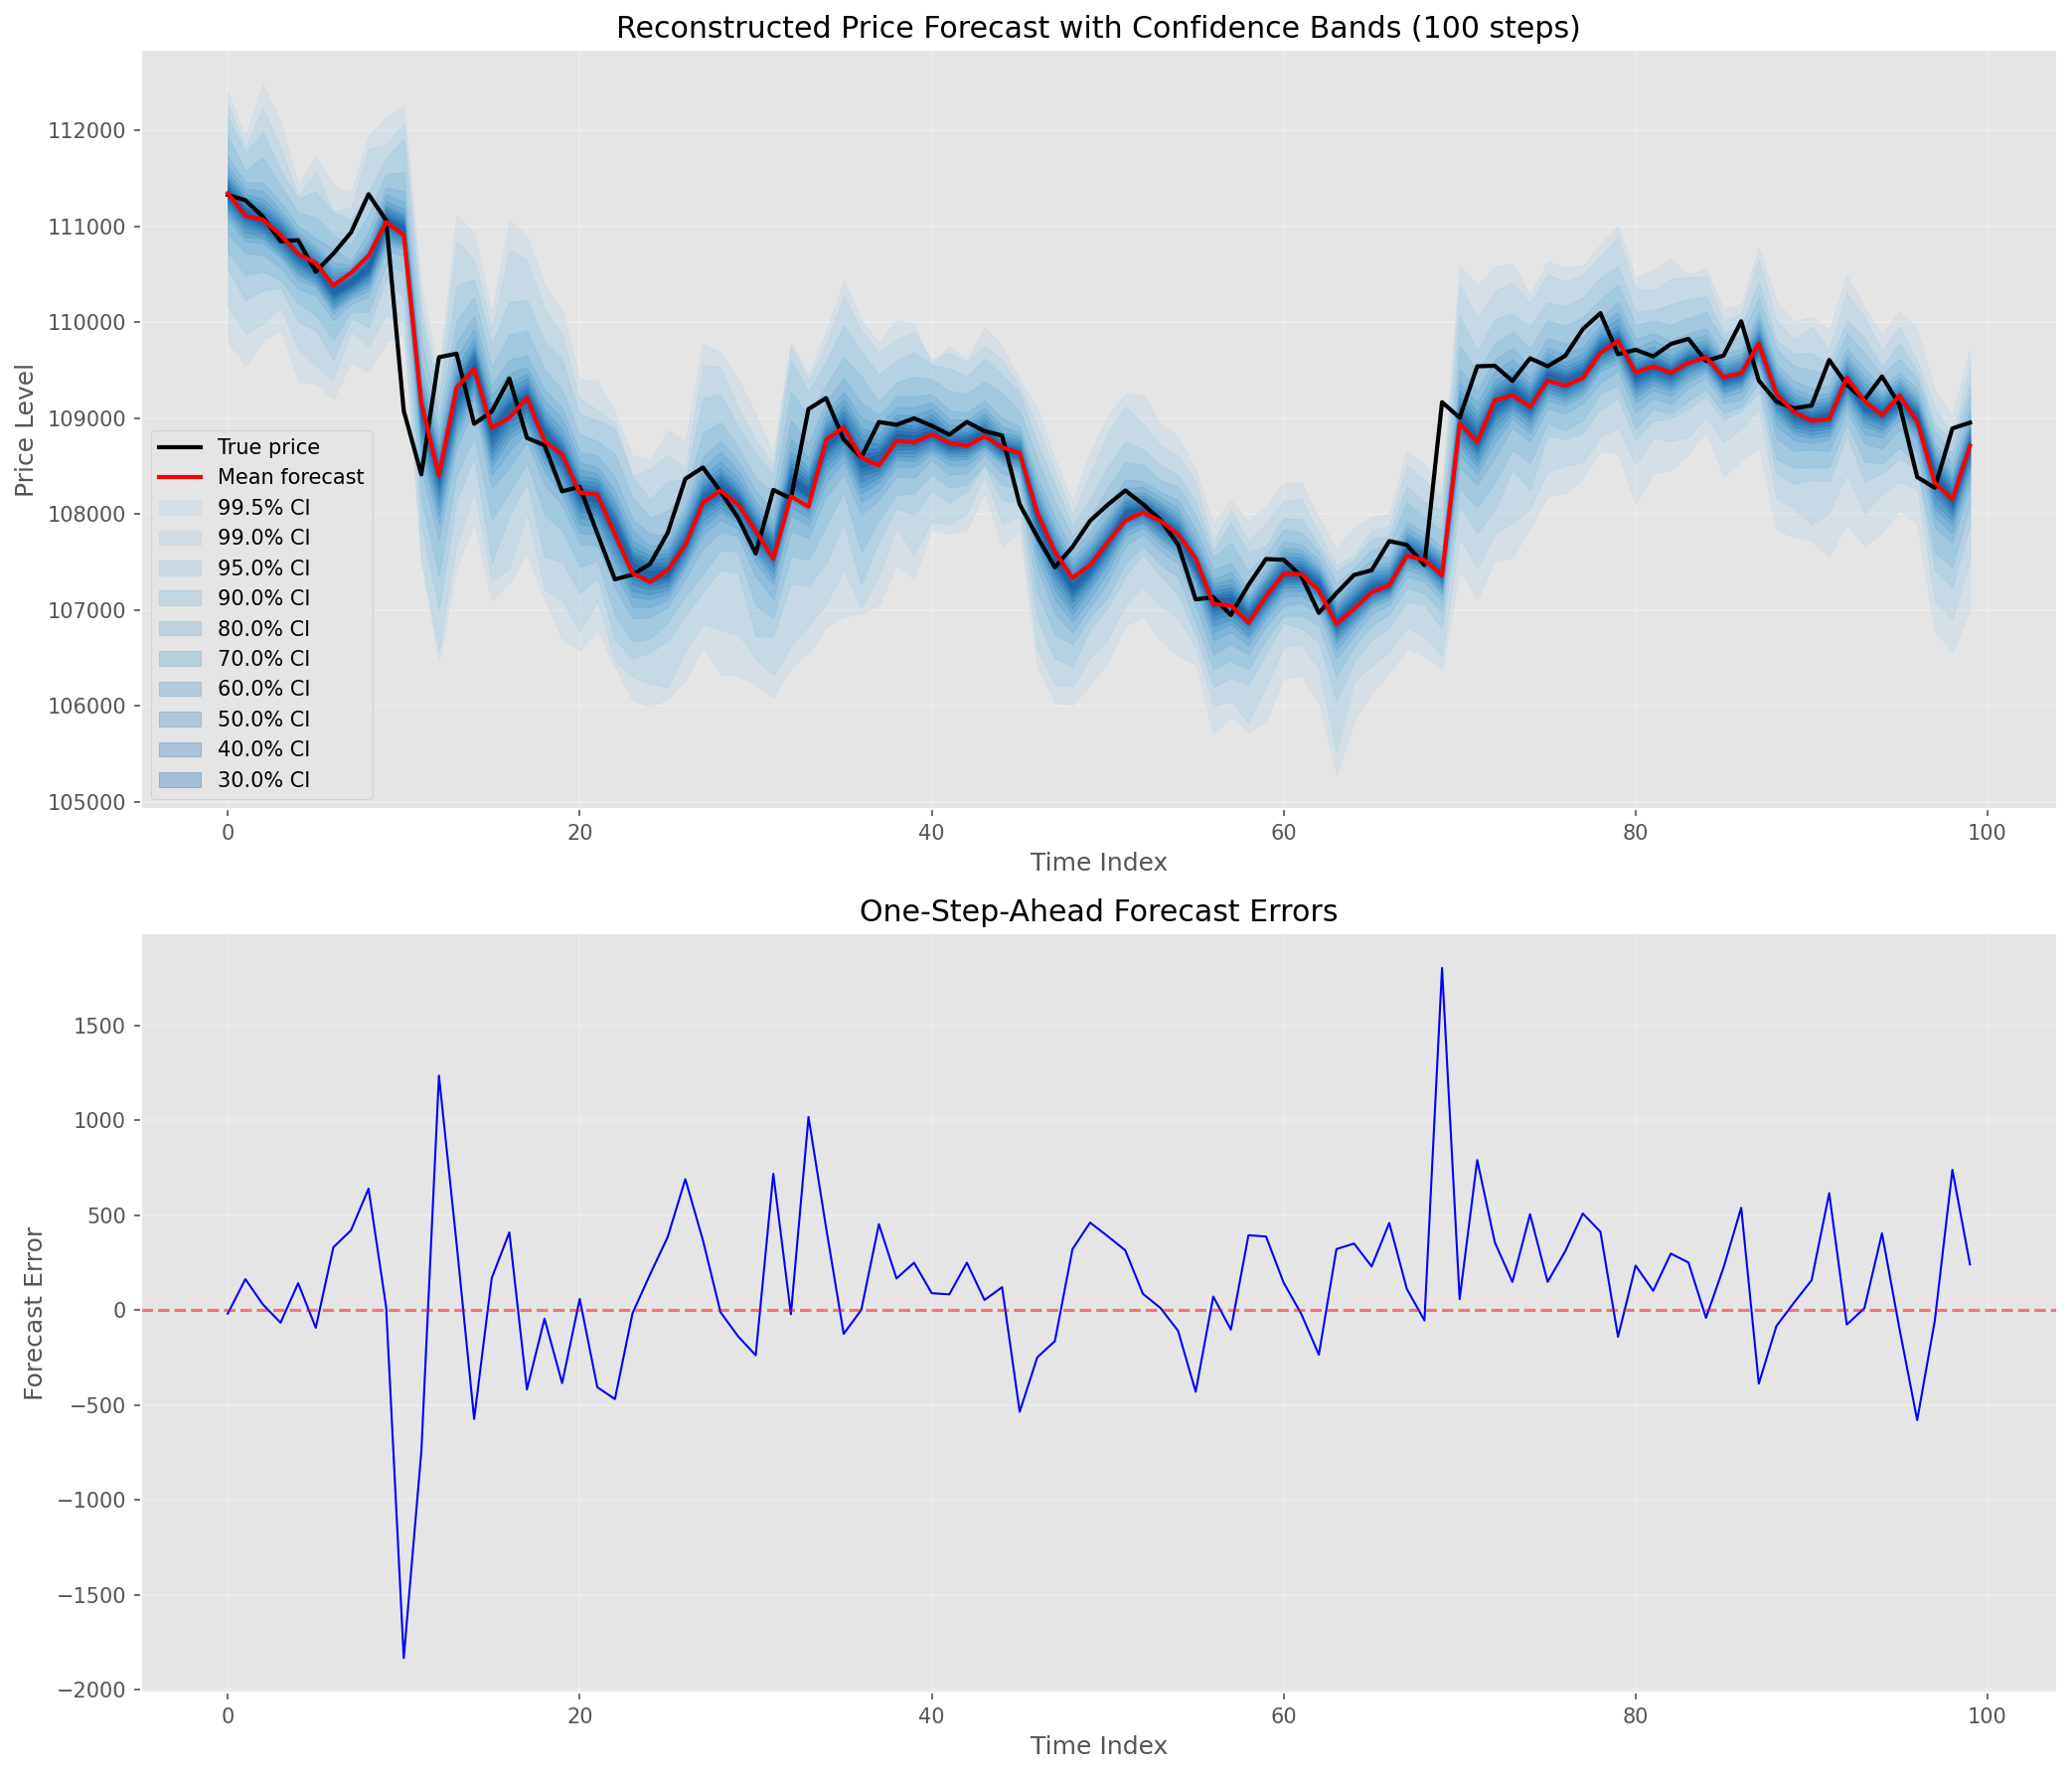


=== Performance Metrics on Reconstructed Price ===
MAE (Price): 292.7963
MAPE (Price): 0.2737%
RMSE (Price): 410.3239
Pearson correlation: 0.9907

=== Confidence Interval Coverage (Price Level) ===
95% CI coverage: 90.75%
90% CI coverage: 83.92%
80% CI coverage: 68.50%
70% CI coverage: 56.42%
60% CI coverage: 45.83%

=== Average Prediction Interval Widths (Price Level) ===
95% CI average width: 1331.6339 (1.25% of mean price)
90% CI average width: 1029.0687 (0.96% of mean price)
80% CI average width: 709.5180 (0.66% of mean price)


In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from utils.fracdiff import get_weights

# Configuration
D_DEFAULT=0.72
MAX_WEIGHTS=1000
plot_len = 100

w = get_weights(D_DEFAULT,MAX_WEIGHTS)

w_filtered = w.flatten()

num_lags = len(w_filtered) - 1  # -1 because last weight is for current value

print(f"Number of weights used: {len(w_filtered)}")
print(f"Number of lags to use: {num_lags}")
print(f"Current weight (should be 1.0): {w_filtered[-1]}")
print(f"First lag weight (should be ~-0.72): {w_filtered[-2]}")

# Function to reconstruct price from fractionally differenced predictions
def reconstruct_price(diff_pred, all_prices, test_start_idx, weights):
    """
    Reconstruct price from fractionally differenced predictions
    diff_pred: differenced predictions 
    all_prices: concatenated train and test actual prices
    test_start_idx: index where test set starts in all_prices
    weights: filtered weights array (last element is weight for current)
    """
    n_pred = len(diff_pred)
    reconstructed = np.zeros(n_pred)
    
    # Weights are ordered from most distant lag to current
    # weights[0] = weight for most distant lag, weights[-1] = weight for current (1.0)
    lag_weights = weights[:-1]  # All weights except current
    current_weight = weights[-1]  # Weight for current value (should be 1.0)
    
    for t in range(n_pred):
        # For recurrent forecast: use all actual prices up to current test position
        current_pos = test_start_idx + t
        lags_available = min(current_pos, num_lags)
        
        # Get actual price lags: [price_{t-n}, ..., price_{t-2}, price_{t-1}]
        lag_prices = all_prices[current_pos-lags_available:current_pos]
        
        # Compute weighted sum for reconstruction
        # Use last lags_available weights (closest to current)
        if len(lag_prices) > 0:
            relevant_weights = lag_weights[-lags_available:]
            weighted_lags = np.sum(relevant_weights * lag_prices)
            reconstructed[t] = diff_pred[t] - weighted_lags  # No division needed since current_weight = 1.0
        else:
            reconstructed[t] = diff_pred[t]
    
    return reconstructed

# Get price history from training data for initial lags
price_train = train_data2['y'].values
price_test = test_data['y'].values

# Concatenate all actual prices
all_prices = np.concatenate([price_train, price_test])
test_start_idx = len(price_train)

# Reconstruct all predictions (mean and quantiles)
predictions_reconstructed = {}

# Reconstruct mean prediction
predictions_reconstructed['mean'] = reconstruct_price(
    predictions['mean'], 
    all_prices,
    test_start_idx,
    w_filtered
)

# Debug first reconstruction
print(f"\n=== Debug First Reconstruction ===")
print(f"First diff prediction: {predictions['mean'][0]}")
print(f"First reconstructed price: {predictions_reconstructed['mean'][0]}")
print(f"First actual test price: {price_test[0]}")
print(f"Difference: {predictions_reconstructed['mean'][0] - price_test[0]}")

# Reconstruct quantile predictions
for i, q in enumerate(quantiles):
    predictions_reconstructed[f'q{q}'] = reconstruct_price(
        predictions[f'q{q}'], 
        all_prices,
        test_start_idx,
        w_filtered
    )

# Plotting reconstructed price with confidence bands
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Reconstructed Price Forecast
plot_end = min(plot_len, len(price_test))
ax1.plot(range(plot_end), price_test[:plot_end], 'k-', 
         label='True price', linewidth=2)
ax1.plot(range(plot_end), predictions_reconstructed['mean'][:plot_end], 
         'r-', label='Mean forecast', linewidth=2)

# Plot confidence bands
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(levels)))
for i, level in enumerate(levels):
    lower_q, upper_q = quantile_mapping[level]
    lower_q_float = float(lower_q)
    upper_q_float = float(upper_q)
    
    ax1.fill_between(
        range(plot_end),
        predictions_reconstructed[f'q{lower_q_float}'][:plot_end],
        predictions_reconstructed[f'q{upper_q_float}'][:plot_end],
        alpha=0.3,
        color=colors[i],
        label=f'{level}% CI' if i < 10 else None  # Limit legend entries
    )

ax1.set_xlabel('Time Index')
ax1.set_ylabel('Price Level')
ax1.set_title(f'Reconstructed Price Forecast with Confidence Bands ({plot_end} steps)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Forecast Errors
errors = price_test[:plot_end] - predictions_reconstructed['mean'][:plot_end]
ax2.plot(range(plot_end), errors, 'b-', linewidth=1)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Forecast Error')
ax2.set_title('One-Step-Ahead Forecast Errors')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics on reconstructed price
mae_price = np.mean(np.abs(price_test - predictions_reconstructed['mean']))
mape_price = mean_absolute_percentage_error(
    y_true=price_test, 
    y_pred=predictions_reconstructed['mean']
)
rmse_price = np.sqrt(np.mean((price_test - predictions_reconstructed['mean'])**2))
corr_price = np.corrcoef(predictions_reconstructed['mean'], price_test)[0, 1]

print("\n=== Performance Metrics on Reconstructed Price ===")
print(f"MAE (Price): {mae_price:.4f}")
print(f"MAPE (Price): {mape_price:.4%}")
print(f"RMSE (Price): {rmse_price:.4f}")
print(f"Pearson correlation: {corr_price:.4f}")

# Coverage statistics for confidence intervals
print("\n=== Confidence Interval Coverage (Price Level) ===")
for level in [95, 90, 80, 70, 60]:
    lower_q, upper_q = quantile_mapping[level]
    lower_q_float = float(lower_q)
    upper_q_float = float(upper_q)
    
    coverage = np.mean((price_test >= predictions_reconstructed[f'q{lower_q_float}']) & 
                      (price_test <= predictions_reconstructed[f'q{upper_q_float}']))
    print(f"{level}% CI coverage: {coverage*100:.2f}%")

# Additional analysis: prediction intervals width
print("\n=== Average Prediction Interval Widths (Price Level) ===")
for level in [95, 90, 80]:
    lower_q, upper_q = quantile_mapping[level]
    lower_q_float = float(lower_q)
    upper_q_float = float(upper_q)
    
    avg_width = np.mean(predictions_reconstructed[f'q{upper_q_float}'] - 
                       predictions_reconstructed[f'q{lower_q_float}'])
    relative_width = avg_width / np.mean(price_test) * 100
    print(f"{level}% CI average width: {avg_width:.4f} ({relative_width:.2f}% of mean price)")